In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

%load_ext autoreload
%autoreload 2

%matplotlib inline
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

In [3]:
import sys
import numpy
import scipy
from matplotlib import pyplot

# Setup the data. Note that we'll fit to the profile above 2*BGlev

In [4]:
if "../src" not in sys.path: sys.path.insert(0, "../src")
from gc_simulation import StarClusterSimulation

if "/supaharris" not in sys.path: sys.path.insert(0, "/supaharris")
from utils import parsec2arcmin

sim = StarClusterSimulation(logger, "NGC 104")
x = sim.deB19_stitched["rad"]
y = sim.deB19_stitched["density"]
yerr = sim.deB19_stitched["density_err"]

# Only include data points above 2 times the background level into the fit
ikeep, = numpy.where(y > 2*sim.deB19_fit["BGlev"])
x, y, yerr = x[ikeep], y[ikeep], yerr[ikeep]

# Setup the model, the log likelihood, log prior, and log probability

We fit the King (1966) model to the data where the quoted uncertainties are underestimated by a constant fractional amount.

$$ \ln p(y \,| \, x, \sigma, W_0, M, r_t, f) = -\frac{1}{2} \Sigma_n \left[ \frac{(y_n - \text{King}[W_0, M, r_t] \,)^2}{s_n^2} + \ln (2 \pi s_n^2) \right]$$
where
$$
s_n^2 = \sigma_n^2 + f^2 \cdot ( \text{King}[W_0, M, r_t] \, )^2
$$

Blabla

$$ 
p (W_0, M, r_t, f\,|\,x,y,\sigma) \propto p(W_0, M, r_t, f)\,p(y\,|\,x,\sigma, W_0, M, r_t, f) \quad .
$$

The likelihood function
$$ p(y|x, \sigma , W_0, M, r_t, f) $$

so the missing component is the "prior" function
$$ p(W_0, M, r_t, f) $$


In this example, we’ll use uniform (so-called "uninformative") priors on $W_0, M, r_t$ and the logarithm of $f$. For example, we'll use the following conservative prior on $m$

\begin{split}p(W_0) = \left \{\begin{array}{ll}
        ? \,, & \mbox{if}\, 0 < W_0 < 14 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}
    
\begin{split}p(M) = \left \{\begin{array}{ll}
        ? \,, & \mbox{if}\, 2 < \log_{10}(W_0) < 6 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}
    
\begin{split}p(r_t) = \left \{\begin{array}{ll}
        ? \,, & \mbox{if}\, 1 < r_t < 300 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}

In code, the log-prior is (up to a constant):


he interested reader should check out [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686) for a much more complete discussion of how to fit a line to data in The Real World™ and why MCMC might come in handy.

# First fit by minimize -log_likelihood

In [5]:
if "/limepy" not in sys.path: sys.path.insert(0, "/limepy")
import limepy   # using tlrh314/limepy fork linked into container


def king(x, W0, M, rt, verbose=False):
    if verbose:
        print("King, W0={0:.1f}, M={1:.1e}, rt={2:.1f}".format(W0, M, rt))

    # Set up the King (1966) model /w Limepy
    king = limepy.limepy(W0, M=M, rt=rt, g=1, project=True, verbose=False)

    # Interpolate the projected surface density profile to allow for arbitrary radii
    interp1d = scipy.interpolate.interp1d(king.R, king.Sigma)

    # However, interp1d needs to stay within bounds. The Limepy profile is
    # only sampled up to the truncation radius rt, and cannot be interpolated
    # beyond. The surface brightness profile, by construction, is zero at the
    # truncation radius. So we set the counts to ZERO equal to small value
    ZERO = 1e-9
    counts = numpy.array([interp1d(xi) if xi < king.rt else ZERO for xi in x])

    return counts


def log_likelihood(theta, x, y, yerr):
    W0, M, rt, log_f = theta
    model = king(x, W0, M, rt)
    sigma2 = yerr ** 2 + model ** 2 * numpy.exp(2 * log_f)
    return -0.5 * numpy.sum((y - model) ** 2 / sigma2 + numpy.log(sigma2))


def log_prior(theta):
    W0, M, rt, log_f = theta
    if 0 < W0 < 14 and 1e2 < M < 1e6 and 1 < rt < 300 and -10.0 < log_f < 1.0:
        return 0.0
    return -numpy.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not numpy.isfinite(lp):
        return -numpy.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [6]:
from scipy.optimize import minimize

W0_deB19 = sim.deB19_fit["W_king"]
M_deB19 = sim.deB19_fit["M_king"]
rt_deB19 = parsec2arcmin(sim.deB19_fit["rt_king"], sim.distance_kpc)
numpy.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = [W0_deB19, M_deB19, rt_deB19, 0.0]
soln = minimize(nll, initial, args=(x, y, yerr))
W0_ml, M_ml, rt_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("W0 = {0:.3f}".format(W0_ml))
print("M = {0:.3f}".format(M_ml))
print("rt = {0:.3f}".format(rt_ml))
print("f = {0:.3f}".format(numpy.exp(log_f_ml)))

Maximum likelihood estimates:
W0 = 8.773
M = 107803.352
rt = 50.584
f = 0.292


King, W0=8.6, M=1.1e+05, rt=40.1
King, W0=8.8, M=1.1e+05, rt=50.6


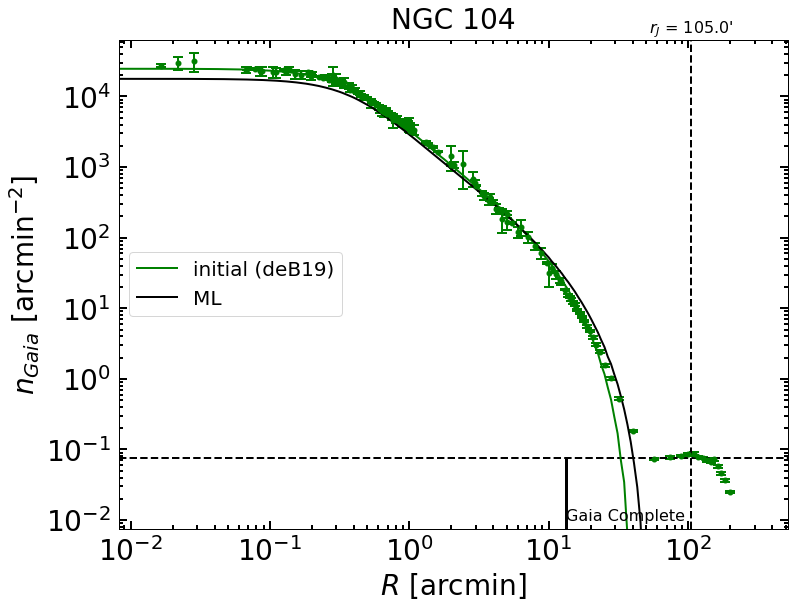

In [7]:
fig, ax = pyplot.subplots(1, 1, figsize=(12, 9))

sim.add_deBoer2019_to_fig(fig)

x0 = numpy.logspace(-3, 3, 256)
ax.plot(x0, king(x0, *initial[0:3], verbose=True), c="g", lw=2, label="initial (deB19)")
ax.plot(x0, king(x0, W0_ml, M_ml, rt_ml, verbose=True), c="k", lw=2, label="ML")

ax.legend(fontsize=20)
pyplot.show()

# Now fit using emcee

In [8]:
import emcee

pos = soln.x + 1e-4 * numpy.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [4:32:15<00:00,  3.27s/it]  


# Inspect the chains

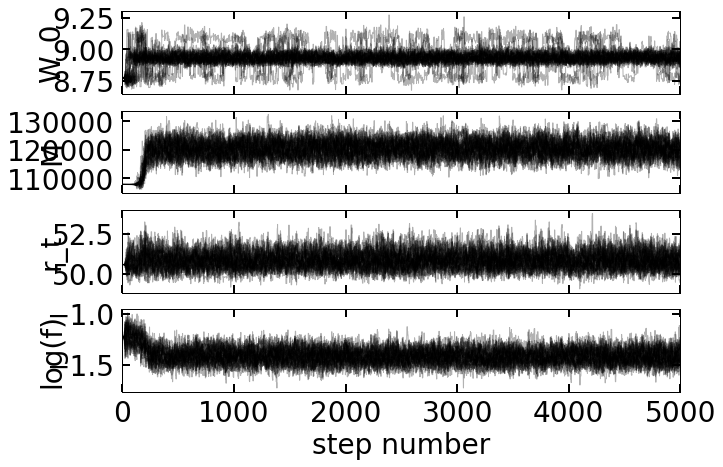

In [9]:
fig, axes = pyplot.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["W_0", "M", "r_t", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [10]:
from emcee.autocorr import AutocorrError

try:
    tau = sampler.get_autocorr_time()
except AutocorrError as e:
    print(e)
    tau = numpy.array([2.41562146, 2.65301037, 2.69963032, 2.7499491])
print(tau)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [  90.4472145   114.29143267   55.72372746   84.78838454]
[ 2.41562146  2.65301037  2.69963032  2.7499491 ]


# Inspect the MLEs 

In [59]:
tau = numpy.array([  90.4472145,   114.29143267,   55.72372746,   84.78838454])
thin = int(numpy.ceil(numpy.mean(tau)/2))
print(thin)
flat_samples = sampler.get_chain(discard=500, thin=thin, flat=True)
print(flat_samples.shape)

44
(3264, 4)


Quantiles:
[(0.16, 8.8977685122438253), (0.5, 8.9323057493403031), (0.84, 8.96969382798647)]
Quantiles:
[(0.16, 117599.50956574304), (0.5, 120340.66310931518), (0.84, 123029.24047842769)]
Quantiles:
[(0.16, 50.350624772483862), (0.5, 50.819999795655164), (0.84, 51.341455388881556)]
Quantiles:
[(0.16, -1.4884448364823213), (0.5, -1.4218965959852625), (0.84, -1.3488081218071206)]


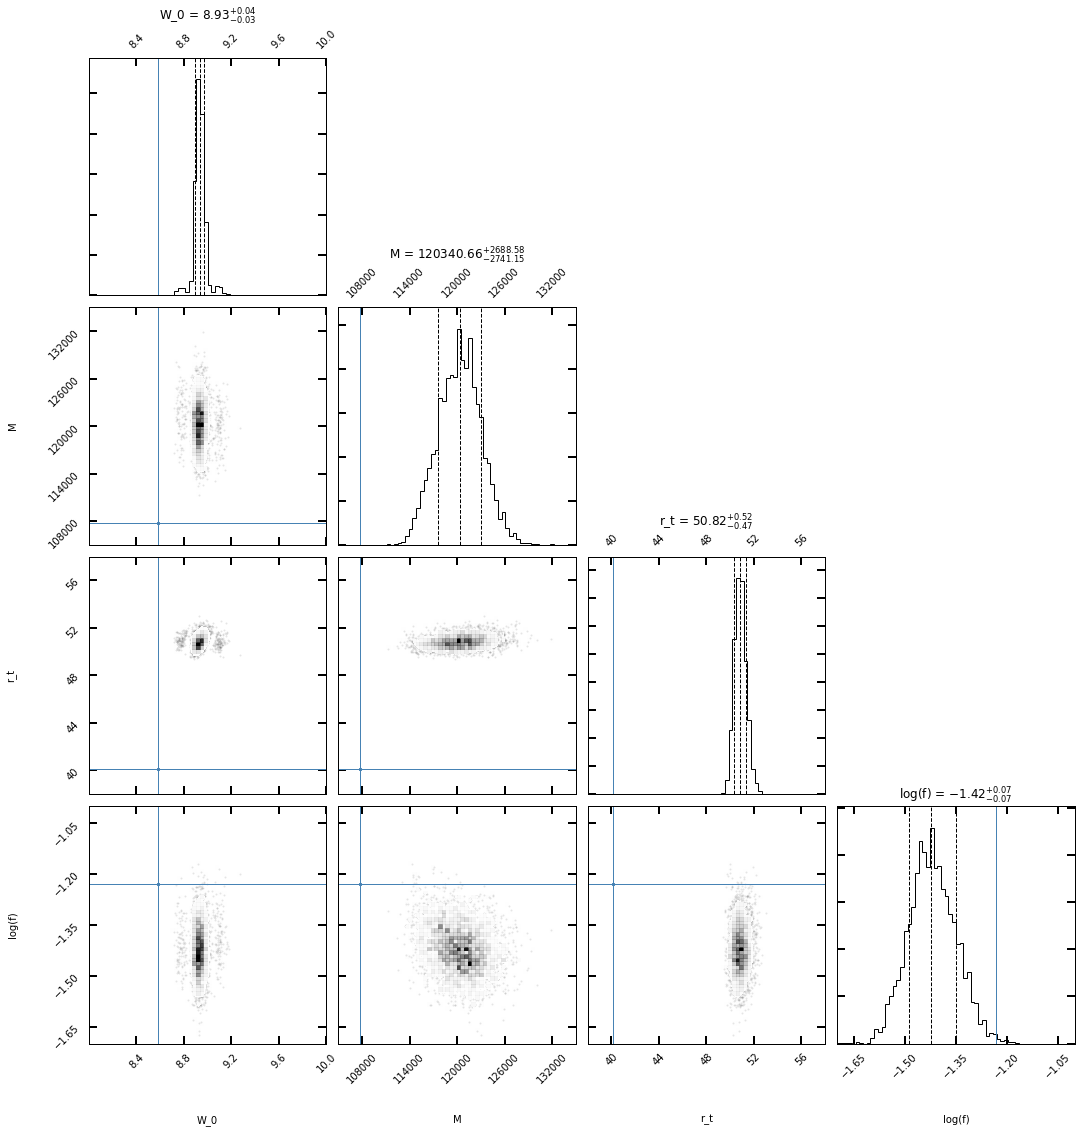

In [58]:
%matplotlib inline
import corner

# Use the best-fit MLEs from deBoer+ 2019 as 'truths', and don't care about this f thingy,
# just use the whatever best-fit log_f_ml
fig, axes = pyplot.subplots(4, 4, figsize=(16, 16), facecolor="white")
fig = corner.corner(
    flat_samples, bins=64, labels=labels, show_titles=True,
    range=[(8.0, 10), (1.05e5, 1.35e5), (38, 58), (-1.7, -1.0)],
    truths=[W0_deB19, M_deB19, rt_deB19, log_f_ml], plot_contours=False,
    quantiles=[0.16, 0.50, 0.84], top_ticks=True, fig=fig, verbose=True
)
pyplot.show(fig)

In [57]:
from IPython.display import display, Math

mcmc_mle = []
for i in range(ndim):
    mcmc = numpy.percentile(flat_samples[:, i], [16, 50, 84])
    mcmc_mle.append(mcmc[1])
    q = numpy.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

King, W0=8.6, M=1.1e+05, rt=40.1
King, W0=8.9, M=1.2e+05, rt=50.8
King, W0=8.8, M=1.1e+05, rt=50.6


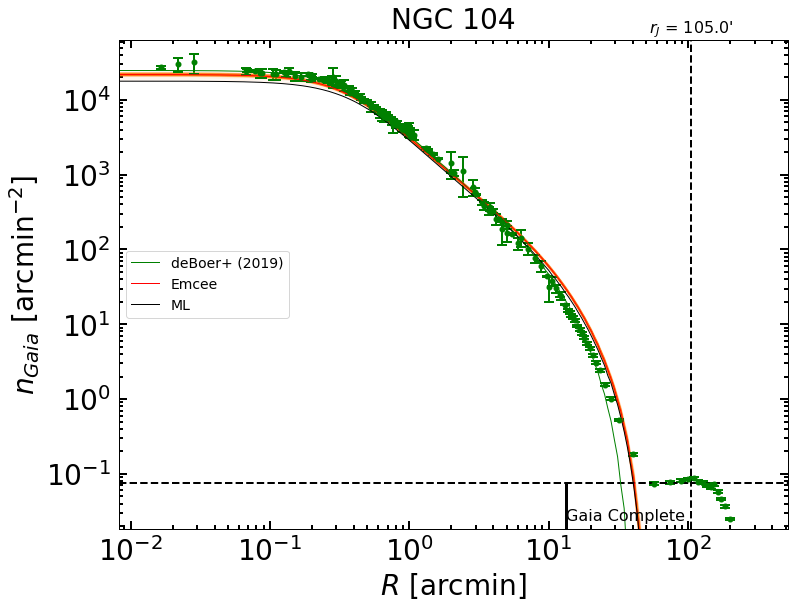

In [56]:
pyplot.style.use("tlrh")
pyplot.figure(figsize=(12, 9))

inds = numpy.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    pyplot.plot(x0, king(x0, *sample[:3]), "C1", alpha=0.1)
sim.add_deBoer2019_to_fig(fig)
# pyplot.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

pyplot.plot(x0, king(x0, *initial[0:3], verbose=True), c="g", lw=1, label="deBoer+ (2019)")
pyplot.plot(x0, king(x0, *mcmc_mle[0:3], verbose=True), c="r", lw=1, label="Emcee")
pyplot.plot(x0, king(x0, W0_ml, M_ml, rt_ml, verbose=True), c="k", lw=1, label="ML")

pyplot.ylim(0.1*y.min(), 2*y.max())

pyplot.legend(fontsize=14)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.show()